# Travel-Time Tomography

**Objective:** Invert travel-time observations from multiple earthquakes and receivers to estimate 3D seismic velocity structure.

**Learning Goals:**
- Understand the linearized tomography inverse problem
- Build and analyze the design matrix (sensitivity kernel)
- Implement iterative velocity model updates
- Assess spatial resolution using checkerboard tests
- Explore the role of ray path coverage and data redundancy
- Quantify model uncertainty and trade-offs

**Overview:**
Unlike earthquake location (where we solve for 4 unknown parameters per event), tomography solves for velocity at every grid point—potentially thousands of unknowns. We'll start with a depth-dependent velocity model, generate synthetic data from multiple earthquakes, then iteratively refine the velocity structure.

## 1. Setup and Imports

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pykonal
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import lsqr
from scipy.interpolate import RegularGridInterpolator

print(f"PyKonal version: {pykonal.__version__}")
print("Setup complete!")

PyKonal version: 0.4.1
Setup complete!


## 2. Define the Domain and Create True Velocity Model

We'll create a 3D velocity model with:
- **Background structure:** Depth-dependent velocity (realistic Earth)
- **Anomalies:** Checkerboard pattern or realistic geological features
- **Grid:** Coarser than the location exercise to keep problem tractable

In [2]:
# Define 3D model domain (coarser than location exercise for computational efficiency)
nx, ny, nz = 51, 51, 26  # Grid points (reduced from 101×101×51)
x_min, x_max = -10.0, 10.0  # km
y_min, y_max = -10.0, 10.0  # km
z_min, z_max = 0.0, 10.0    # km (positive downward)

# Create coordinate arrays
x = np.linspace(x_min, x_max, nx)
y = np.linspace(y_min, y_max, ny)
z = np.linspace(z_min, z_max, nz)

# Create 3D meshgrid
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Create TRUE velocity model (this is what we'll try to recover)
# Background velocity: increases linearly with depth
v0 = 3.0  # Surface velocity (km/s)
velocity_gradient = 0.15  # km/s per km depth
velocity_true = v0 + velocity_gradient * Z

# Add velocity anomalies - CHECKERBOARD PATTERN for resolution testing
checkerboard_wavelength_x = 4.0  # km (wavelength in x)
checkerboard_wavelength_y = 4.0  # km (wavelength in y)
checkerboard_wavelength_z = 2.5  # km (wavelength in z)
checkerboard_amplitude = 0.3  # km/s (±15% perturbation)

# Create checkerboard using sin functions
checkerboard = checkerboard_amplitude * (
    np.sin(2 * np.pi * X / checkerboard_wavelength_x) *
    np.sin(2 * np.pi * Y / checkerboard_wavelength_y) *
    np.sin(2 * np.pi * Z / checkerboard_wavelength_z)
)

# Apply checkerboard anomalies to background model
velocity_true += checkerboard

# Ensure velocities are positive
velocity_true = np.maximum(velocity_true, 2.0)

print(f"True velocity model created")
print(f"  Domain: [{x_min}, {x_max}] × [{y_min}, {y_max}] × [{z_min}, {z_max}] km")
print(f"  Grid size: {nx} × {ny} × {nz}")
print(f"  Grid spacing: {(x_max-x_min)/(nx-1):.2f} × {(y_max-y_min)/(ny-1):.2f} × {(z_max-z_min)/(nz-1):.2f} km")
print(f"  Velocity range: {velocity_true.min():.2f} - {velocity_true.max():.2f} km/s")
print(f"  Checkerboard wavelengths: {checkerboard_wavelength_x} × {checkerboard_wavelength_y} × {checkerboard_wavelength_z} km")
print(f"  Checkerboard amplitude: ±{checkerboard_amplitude} km/s")

True velocity model created
  Domain: [-10.0, 10.0] × [-10.0, 10.0] × [0.0, 10.0] km
  Grid size: 51 × 51 × 26
  Grid spacing: 0.40 × 0.40 × 0.40 km
  Velocity range: 2.83 - 4.67 km/s
  Checkerboard wavelengths: 4.0 × 4.0 × 2.5 km
  Checkerboard amplitude: ±0.3 km/s


### Visualize True Velocity Model

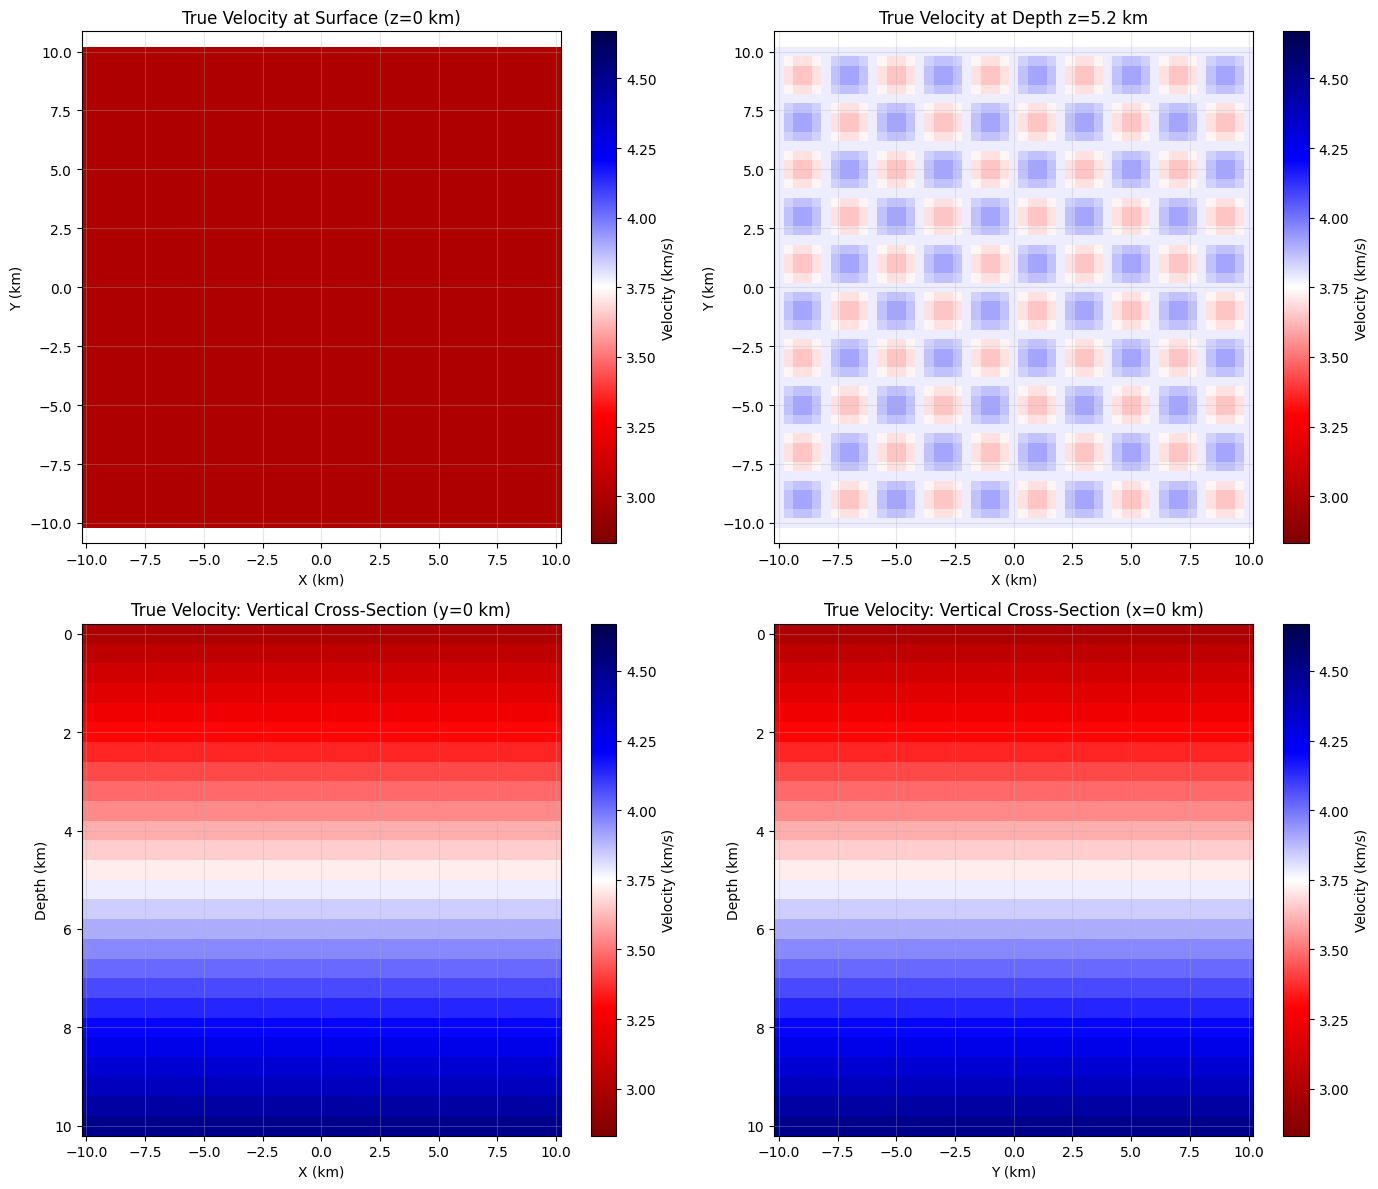

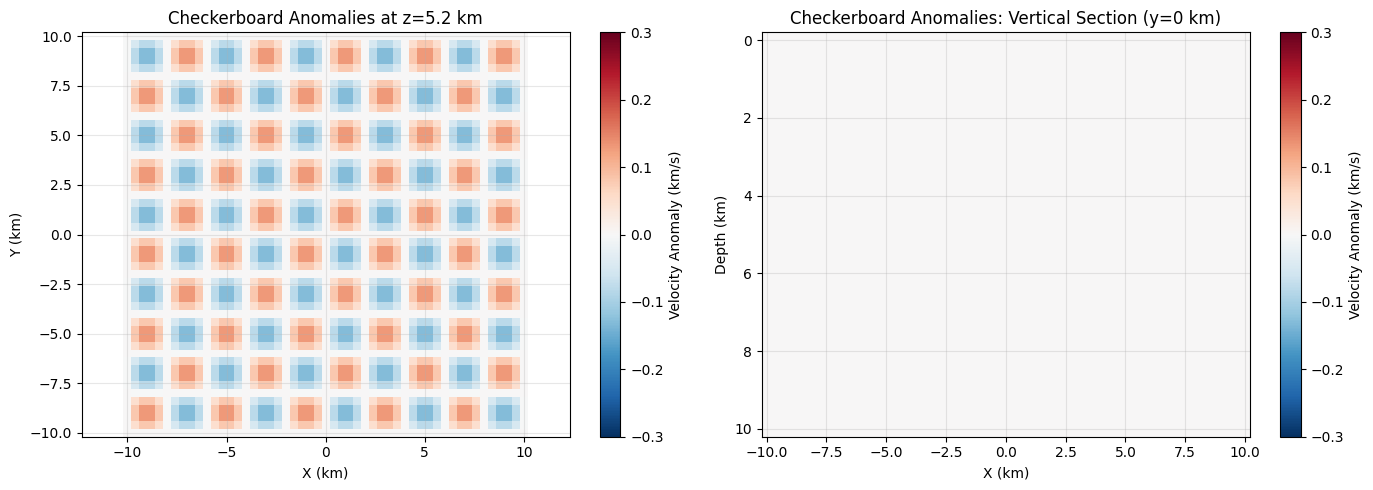

In [3]:
# Plot true velocity model slices
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Surface slice (z=0)
ax = axes[0, 0]
im = ax.pcolormesh(X[:, :, 0], Y[:, :, 0], velocity_true[:, :, 0], 
                   shading='auto', cmap='seismic_r', vmin=velocity_true.min(), vmax=velocity_true.max())
plt.colorbar(im, ax=ax, label='Velocity (km/s)')
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_title('True Velocity at Surface (z=0 km)')
ax.axis('equal')
ax.grid(True, alpha=0.3)

# Mid-depth slice (z=5 km)
ax = axes[0, 1]
mid_z_idx = nz // 2
im = ax.pcolormesh(X[:, :, mid_z_idx], Y[:, :, mid_z_idx], velocity_true[:, :, mid_z_idx], 
                   shading='auto', cmap='seismic_r', vmin=velocity_true.min(), vmax=velocity_true.max())
plt.colorbar(im, ax=ax, label='Velocity (km/s)')
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_title(f'True Velocity at Depth z={z[mid_z_idx]:.1f} km')
ax.axis('equal')
ax.grid(True, alpha=0.3)

# Vertical slice at y=0
ax = axes[1, 0]
y_mid_idx = ny // 2
im = ax.pcolormesh(X[:, y_mid_idx, :], Z[:, y_mid_idx, :], velocity_true[:, y_mid_idx, :], 
                   shading='auto', cmap='seismic_r', vmin=velocity_true.min(), vmax=velocity_true.max())
plt.colorbar(im, ax=ax, label='Velocity (km/s)')
ax.set_xlabel('X (km)')
ax.set_ylabel('Depth (km)')
ax.set_title('True Velocity: Vertical Cross-Section (y=0 km)')
ax.invert_yaxis()
ax.grid(True, alpha=0.3)

# Vertical slice at x=0
ax = axes[1, 1]
x_mid_idx = nx // 2
im = ax.pcolormesh(Y[x_mid_idx, :, :], Z[x_mid_idx, :, :], velocity_true[x_mid_idx, :, :], 
                   shading='auto', cmap='seismic_r', vmin=velocity_true.min(), vmax=velocity_true.max())
plt.colorbar(im, ax=ax, label='Velocity (km/s)')
ax.set_xlabel('Y (km)')
ax.set_ylabel('Depth (km)')
ax.set_title('True Velocity: Vertical Cross-Section (x=0 km)')
ax.invert_yaxis()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot checkerboard anomalies separately
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Horizontal slice of anomalies
ax = axes[0]
im = ax.pcolormesh(X[:, :, mid_z_idx], Y[:, :, mid_z_idx], 
                   checkerboard[:, :, mid_z_idx], 
                   shading='auto', cmap='RdBu_r', 
                   vmin=-checkerboard_amplitude, vmax=checkerboard_amplitude)
plt.colorbar(im, ax=ax, label='Velocity Anomaly (km/s)')
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_title(f'Checkerboard Anomalies at z={z[mid_z_idx]:.1f} km')
ax.axis('equal')
ax.grid(True, alpha=0.3)

# Vertical slice of anomalies
ax = axes[1]
im = ax.pcolormesh(X[:, y_mid_idx, :], Z[:, y_mid_idx, :], 
                   checkerboard[:, y_mid_idx, :], 
                   shading='auto', cmap='RdBu_r',
                   vmin=-checkerboard_amplitude, vmax=checkerboard_amplitude)
plt.colorbar(im, ax=ax, label='Velocity Anomaly (km/s)')
ax.set_xlabel('X (km)')
ax.set_ylabel('Depth (km)')
ax.set_title('Checkerboard Anomalies: Vertical Section (y=0 km)')
ax.invert_yaxis()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Define Earthquake Sources and Seismic Network

**Key consideration:** Ray path coverage determines what parts of the model we can resolve.

- **Receivers:** Surface network (similar to location exercise)
- **Sources:** Multiple earthquakes at various depths and locations
- **Progressive experiment:** Start with few events, then increase to see resolution improvement

In [5]:
# Define receiver array at surface (z=0) - similar to location exercise
sensor_spacing = 2.0  # km
x_sensors = np.arange(-8, 8.1, sensor_spacing)
y_sensors = np.arange(-8, 8.1, sensor_spacing)
X_sensors, Y_sensors = np.meshgrid(x_sensors, y_sensors)
Z_sensors = np.zeros_like(X_sensors)  # All at surface

# Flatten sensor coordinates
receiver_coords = np.column_stack([
    X_sensors.ravel(),
    Y_sensors.ravel(),
    Z_sensors.ravel()
])
n_receivers = len(receiver_coords)

print(f"Receiver Network:")
print(f"  Number of receivers: {n_receivers}")
print(f"  Receiver spacing: {sensor_spacing} km")
print(f"  All receivers at surface (z=0 km)")

# Define earthquake source locations (KNOWN positions for tomography)
# We'll create multiple scenarios with different numbers of sources

# Scenario 1: Sparse source distribution (few earthquakes)
np.random.seed(42)  # For reproducibility
n_sources_sparse = 10
source_coords_sparse = np.column_stack([
    np.random.uniform(x_min + 2, x_max - 2, n_sources_sparse),
    np.random.uniform(y_min + 2, y_max - 2, n_sources_sparse),
    np.random.uniform(2.0, 8.0, n_sources_sparse)  # Between 2-8 km depth
])

# Scenario 2: Moderate source distribution
n_sources_moderate = 25
source_coords_moderate = np.column_stack([
    np.random.uniform(x_min + 2, x_max - 2, n_sources_moderate),
    np.random.uniform(y_min + 2, y_max - 2, n_sources_moderate),
    np.random.uniform(2.0, 8.0, n_sources_moderate)
])

# Scenario 3: Dense source distribution (many earthquakes)
n_sources_dense = 50
source_coords_dense = np.column_stack([
    np.random.uniform(x_min + 2, x_max - 2, n_sources_dense),
    np.random.uniform(y_min + 2, y_max - 2, n_sources_dense),
    np.random.uniform(2.0, 8.0, n_sources_dense)
])

# Start with moderate distribution for main workflow
source_coords = source_coords_moderate
n_sources = n_sources_moderate

print(f"\nEarthquake Sources:")
print(f"  Number of sources (moderate): {n_sources}")
print(f"  Source depth range: 2.0 - 8.0 km")
print(f"  Total source-receiver pairs: {n_sources * n_receivers}")
print(f"\nAlternative scenarios available:")
print(f"  Sparse:   {n_sources_sparse} sources ({n_sources_sparse * n_receivers} pairs)")
print(f"  Moderate: {n_sources_moderate} sources ({n_sources_moderate * n_receivers} pairs)")
print(f"  Dense:    {n_sources_dense} sources ({n_sources_dense * n_receivers} pairs)")

Receiver Network:
  Number of receivers: 81
  Receiver spacing: 2.0 km
  All receivers at surface (z=0 km)

Earthquake Sources:
  Number of sources (moderate): 25
  Source depth range: 2.0 - 8.0 km
  Total source-receiver pairs: 2025

Alternative scenarios available:
  Sparse:   10 sources (810 pairs)
  Moderate: 25 sources (2025 pairs)
  Dense:    50 sources (4050 pairs)


### Visualize Source-Receiver Geometry

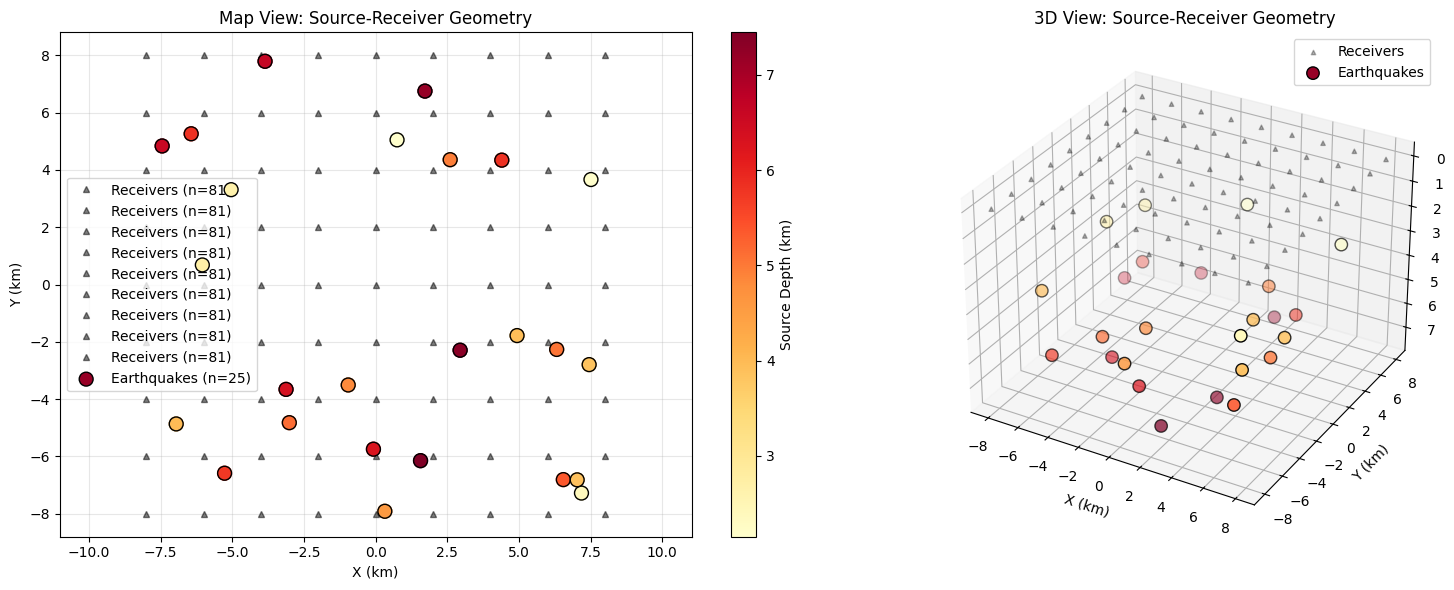

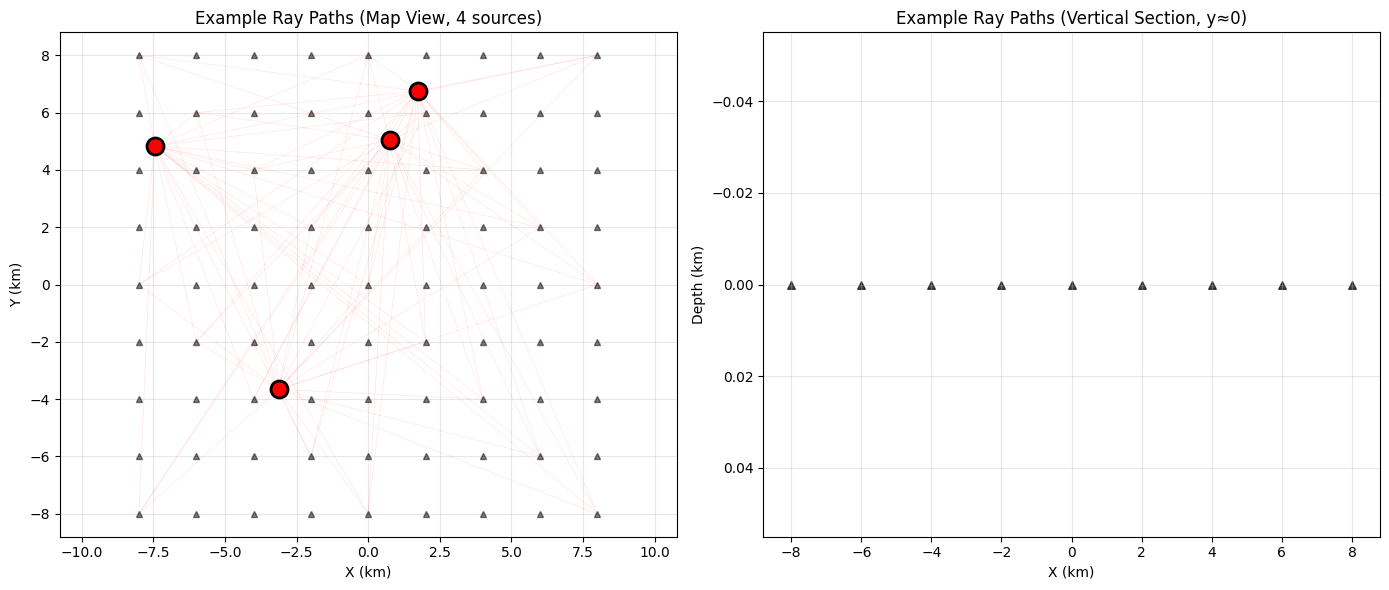


Ray path statistics:
  Total number of rays: 2025
  Average rays per source: 81
  Average rays per receiver: 25


In [6]:
# Visualize source-receiver geometry
fig = plt.figure(figsize=(16, 6))

# 2D map view
ax1 = fig.add_subplot(121)
ax1.plot(X_sensors, Y_sensors, 'k^', markersize=4, alpha=0.5, label=f'Receivers (n={n_receivers})')
ax1.scatter(source_coords[:, 0], source_coords[:, 1], 
           c=source_coords[:, 2], cmap='YlOrRd', 
           s=100, edgecolors='black', linewidths=1, 
           label=f'Earthquakes (n={n_sources})', zorder=10)
cbar = plt.colorbar(ax1.scatter(source_coords[:, 0], source_coords[:, 1], 
                                c=source_coords[:, 2], cmap='YlOrRd', s=100), 
                   ax=ax1, label='Source Depth (km)')
ax1.set_xlabel('X (km)')
ax1.set_ylabel('Y (km)')
ax1.set_title('Map View: Source-Receiver Geometry')
ax1.axis('equal')
ax1.grid(True, alpha=0.3)
ax1.legend()

# 3D view
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X_sensors, Y_sensors, Z_sensors, c='black', marker='^', s=10, alpha=0.3, label='Receivers')
ax2.scatter(source_coords[:, 0], source_coords[:, 1], source_coords[:, 2], 
           c=source_coords[:, 2], cmap='YlOrRd', 
           s=80, edgecolors='black', linewidths=1, label='Earthquakes')
ax2.set_xlabel('X (km)')
ax2.set_ylabel('Y (km)')
ax2.set_zlabel('Depth (km)')
ax2.set_title('3D View: Source-Receiver Geometry')
ax2.invert_zaxis()
ax2.legend()

plt.tight_layout()
plt.show()

# Show example ray paths from a few sources
fig = plt.figure(figsize=(14, 6))

# Select a few sources to visualize rays
example_sources = [0, n_sources//4, n_sources//2, 3*n_sources//4]

ax1 = fig.add_subplot(121)
ax1.plot(X_sensors, Y_sensors, 'k^', markersize=4, alpha=0.5)
for i_src in example_sources:
    src = source_coords[i_src]
    # Draw lines from source to all receivers
    for rec in receiver_coords[::4]:  # Sample every 4th receiver for clarity
        ax1.plot([src[0], rec[0]], [src[1], rec[1]], 'r-', alpha=0.1, linewidth=0.5)
    ax1.scatter(src[0], src[1], s=150, c='red', edgecolors='black', 
               linewidths=2, zorder=10)
ax1.set_xlabel('X (km)')
ax1.set_ylabel('Y (km)')
ax1.set_title(f'Example Ray Paths (Map View, {len(example_sources)} sources)')
ax1.axis('equal')
ax1.grid(True, alpha=0.3)

# Vertical cross-section
ax2 = fig.add_subplot(122)
# Show rays in vertical plane at y=0
y_tol = 2.0  # Include receivers/sources within ±2 km of y=0
for i_src in example_sources:
    src = source_coords[i_src]
    if abs(src[1]) < y_tol:
        for rec in receiver_coords:
            if abs(rec[1]) < y_tol:
                ax2.plot([src[0], rec[0]], [src[2], rec[2]], 'r-', alpha=0.15, linewidth=0.5)
        ax2.scatter(src[0], src[2], s=150, c='red', edgecolors='black', 
                   linewidths=2, zorder=10)

# Plot receivers at surface
receivers_near_y0 = receiver_coords[np.abs(receiver_coords[:, 1]) < y_tol]
ax2.scatter(receivers_near_y0[:, 0], receivers_near_y0[:, 2], 
           c='black', marker='^', s=30, alpha=0.7)
ax2.set_xlabel('X (km)')
ax2.set_ylabel('Depth (km)')
ax2.set_title('Example Ray Paths (Vertical Section, y≈0)')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nRay path statistics:")
print(f"  Total number of rays: {n_sources * n_receivers}")
print(f"  Average rays per source: {n_receivers}")
print(f"  Average rays per receiver: {n_sources}")

## 4. Forward Problem: Compute Synthetic Travel Times

For each earthquake-receiver pair, solve the eikonal equation through the **true** velocity model to generate synthetic observed data.

In [7]:
# Compute synthetic travel times for all source-receiver pairs
print("Computing synthetic travel times using TRUE velocity model...")
print(f"Total number of source-receiver pairs: {n_sources * n_receivers}")
print("This may take a few minutes...\n")

# Initialize data vector to store all travel times
n_data = n_sources * n_receivers
travel_times_true = np.zeros(n_data)
source_indices = np.zeros(n_data, dtype=int)  # Track which source
receiver_indices = np.zeros(n_data, dtype=int)  # Track which receiver

# Loop over all earthquake sources
data_idx = 0
for i_src in range(n_sources):
    if (i_src + 1) % 5 == 0 or i_src == 0:
        print(f"  Processing source {i_src + 1}/{n_sources}...")
    
    # Get source location
    src_x, src_y, src_z = source_coords[i_src]
    
    # Setup PyKonal solver for this source
    solver = pykonal.EikonalSolver(coord_sys="cartesian")
    solver.velocity.min_coords = x_min, y_min, z_min
    solver.velocity.node_intervals = (
        (x_max - x_min) / (nx - 1),
        (y_max - y_min) / (ny - 1),
        (z_max - z_min) / (nz - 1)
    )
    solver.velocity.npts = nx, ny, nz
    solver.velocity.values = velocity_true  # Use TRUE model
    
    # Set source location
    src_idx = (
        int((src_x - x_min) / (x_max - x_min) * (nx - 1)),
        int((src_y - y_min) / (y_max - y_min) * (ny - 1)),
        int((src_z - z_min) / (z_max - z_min) * (nz - 1))
    )
    
    # Handle boundary cases
    src_idx = (
        max(0, min(src_idx[0], nx - 1)),
        max(0, min(src_idx[1], ny - 1)),
        max(0, min(src_idx[2], nz - 1))
    )
    
    solver.traveltime.values[src_idx] = 0.0
    solver.unknown[src_idx] = False
    solver.trial.push(*src_idx)
    
    # Solve eikonal equation
    solver.solve()
    
    # Interpolate travel times at all receiver locations
    interpolator = RegularGridInterpolator(
        (x, y, z),
        solver.traveltime.values,
        method='linear',
        bounds_error=False,
        fill_value=np.inf
    )
    
    times_at_receivers = interpolator(receiver_coords)
    
    # Store in data vector
    for i_rec in range(n_receivers):
        travel_times_true[data_idx] = times_at_receivers[i_rec]
        source_indices[data_idx] = i_src
        receiver_indices[data_idx] = i_rec
        data_idx += 1

print(f"\nTravel time computation complete!")
print(f"  Total data points: {n_data}")
print(f"  Travel time range: {travel_times_true.min():.3f} - {travel_times_true.max():.3f} s")
print(f"  Mean travel time: {travel_times_true.mean():.3f} s")

# Add Gaussian noise to simulate measurement uncertainty
noise_level = 0.05  # seconds (50 ms) - same as location exercise
np.random.seed(123)  # For reproducibility
noise = np.random.normal(0, noise_level, n_data)
travel_times_obs = travel_times_true + noise

print(f"\nAdded noise:")
print(f"  Noise level (σ): {noise_level:.3f} s")
print(f"  Observed travel time range: {travel_times_obs.min():.3f} - {travel_times_obs.max():.3f} s")
print(f"  SNR (mean/noise): {travel_times_true.mean() / noise_level:.1f}")

Computing synthetic travel times using TRUE velocity model...
Total number of source-receiver pairs: 2025
This may take a few minutes...

  Processing source 1/25...
  Processing source 5/25...
  Processing source 10/25...
  Processing source 15/25...
  Processing source 10/25...
  Processing source 15/25...
  Processing source 20/25...
  Processing source 25/25...

Travel time computation complete!
  Total data points: 2025
  Travel time range: 0.747 - 6.578 s
  Mean travel time: 3.211 s

Added noise:
  Noise level (σ): 0.050 s
  Observed travel time range: 0.685 - 6.572 s
  SNR (mean/noise): 64.2
  Processing source 20/25...
  Processing source 25/25...

Travel time computation complete!
  Total data points: 2025
  Travel time range: 0.747 - 6.578 s
  Mean travel time: 3.211 s

Added noise:
  Noise level (σ): 0.050 s
  Observed travel time range: 0.685 - 6.572 s
  SNR (mean/noise): 64.2


### Visualize Observed Data

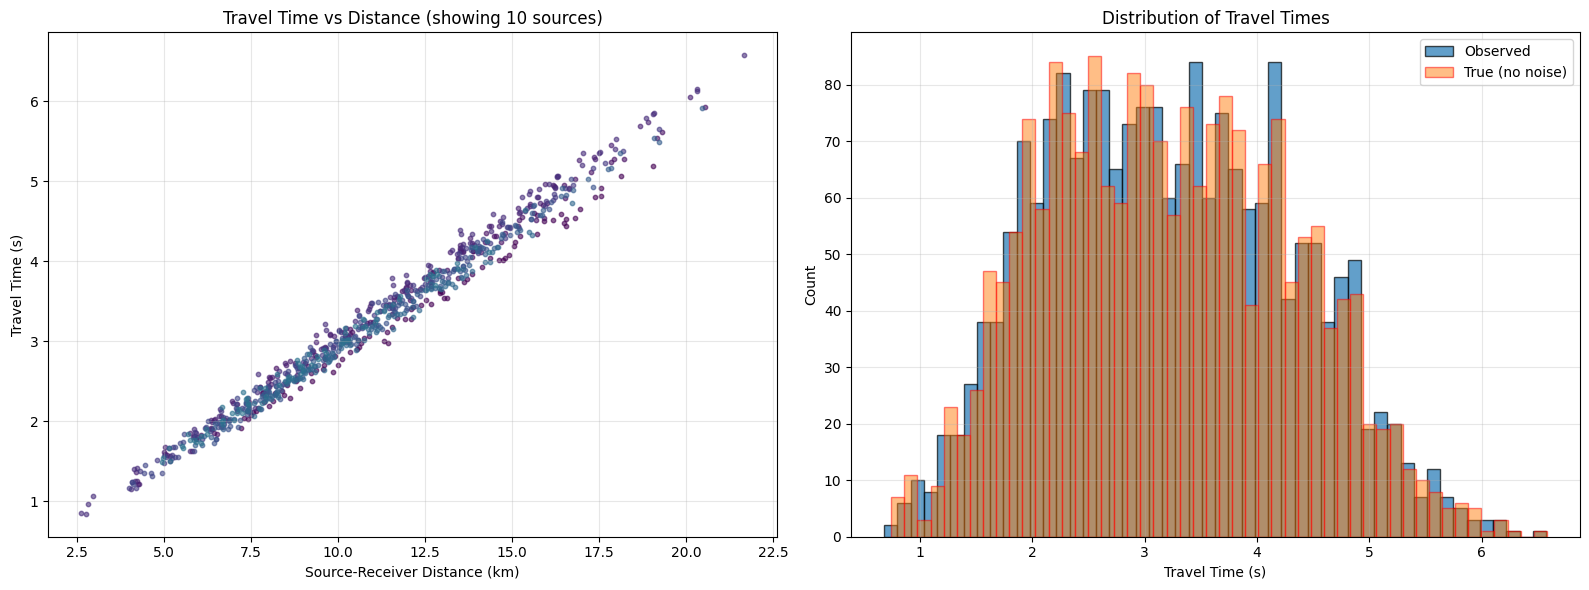

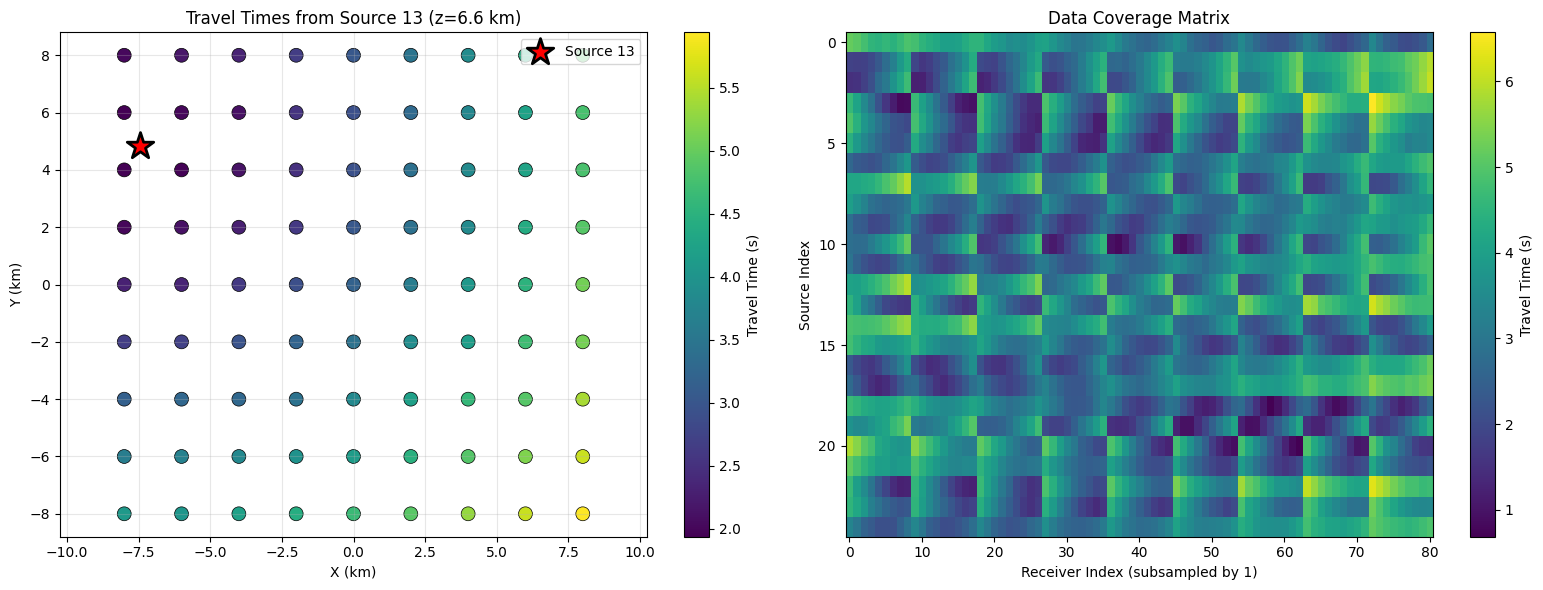


Data Statistics:
  Total observations: 2025
  Observations per source: 81
  Observations per receiver: 25
  Distance range: 2.27 - 21.67 km
  Mean distance: 10.85 km
  Travel time range: 0.685 - 6.572 s
  Data completeness: 100% (all source-receiver pairs)


In [8]:
# Visualize observed travel-time data

# Plot 1: Travel time vs. distance for each earthquake
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calculate source-receiver distances
distances = np.zeros(n_data)
for i in range(n_data):
    src = source_coords[source_indices[i]]
    rec = receiver_coords[receiver_indices[i]]
    distances[i] = np.sqrt(
        (src[0] - rec[0])**2 + 
        (src[1] - rec[1])**2 + 
        (src[2] - rec[2])**2
    )

# Plot travel time vs. distance
ax = axes[0]
# Plot each source with different color
colors = plt.cm.viridis(np.linspace(0, 1, n_sources))
for i_src in range(min(n_sources, 10)):  # Plot first 10 sources for clarity
    mask = source_indices == i_src
    ax.scatter(distances[mask], travel_times_obs[mask], 
              c=[colors[i_src]], s=10, alpha=0.6, label=f'Source {i_src+1}' if i_src < 5 else '')

ax.set_xlabel('Source-Receiver Distance (km)')
ax.set_ylabel('Travel Time (s)')
ax.set_title(f'Travel Time vs Distance (showing {min(n_sources, 10)} sources)')
ax.grid(True, alpha=0.3)
if n_sources <= 5:
    ax.legend()

# Plot 2: Histogram of travel times
ax = axes[1]
ax.hist(travel_times_obs, bins=50, edgecolor='black', alpha=0.7, label='Observed')
ax.hist(travel_times_true, bins=50, edgecolor='red', alpha=0.5, label='True (no noise)')
ax.set_xlabel('Travel Time (s)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Travel Times')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

# Plot 3: Data coverage - show which source-receiver pairs exist
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Map view: Show travel times for one example source
example_src_idx = n_sources // 2
ax = axes[0]
mask = source_indices == example_src_idx
times_example = travel_times_obs[mask]
rec_coords_example = receiver_coords[receiver_indices[mask]]

scatter = ax.scatter(rec_coords_example[:, 0], rec_coords_example[:, 1],
                    c=times_example, s=100, cmap='viridis',
                    edgecolors='black', linewidths=0.5)
ax.scatter(source_coords[example_src_idx, 0], source_coords[example_src_idx, 1],
          c='red', marker='*', s=400, edgecolors='black', linewidths=2,
          label=f'Source {example_src_idx+1}', zorder=10)
plt.colorbar(scatter, ax=ax, label='Travel Time (s)')
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_title(f'Travel Times from Source {example_src_idx+1} (z={source_coords[example_src_idx, 2]:.1f} km)')
ax.axis('equal')
ax.grid(True, alpha=0.3)
ax.legend()

# Data coverage matrix: sources vs receivers (subsampled for visualization)
ax = axes[1]
# Create a matrix showing data coverage
subsample = max(1, n_receivers // 50)  # Subsample for visualization
coverage_matrix = np.zeros((n_sources, n_receivers // subsample))
for i in range(n_data):
    i_src = source_indices[i]
    i_rec = receiver_indices[i] // subsample
    if i_rec < coverage_matrix.shape[1]:
        coverage_matrix[i_src, i_rec] = travel_times_obs[i]

im = ax.imshow(coverage_matrix, aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(im, ax=ax, label='Travel Time (s)')
ax.set_xlabel(f'Receiver Index (subsampled by {subsample})')
ax.set_ylabel('Source Index')
ax.set_title('Data Coverage Matrix')

plt.tight_layout()
plt.show()

# Print data statistics
print(f"\nData Statistics:")
print(f"  Total observations: {n_data}")
print(f"  Observations per source: {n_receivers}")
print(f"  Observations per receiver: {n_sources}")
print(f"  Distance range: {distances.min():.2f} - {distances.max():.2f} km")
print(f"  Mean distance: {distances.mean():.2f} km")
print(f"  Travel time range: {travel_times_obs.min():.3f} - {travel_times_obs.max():.3f} s")
print(f"  Data completeness: 100% (all source-receiver pairs)")

## 5. Tomography Inverse Problem: Theory

### 5.1 Linearization and the Fréchet Matrix

The forward relation is:
$$t_{ij} = \int_{\text{ray}} s(\mathbf{x}) \, dl$$
where $t_{ij}$ is the travel time from source $i$ to receiver $j$, and $s(\mathbf{x}) = 1/c(\mathbf{x})$ is slowness.

**Linearization:** Given a reference model $s_0(\mathbf{x})$ and perturbation $\delta s(\mathbf{x})$:
$$\delta t_{ij} \approx \int_{\text{ray}_0} \delta s(\mathbf{x}) \, dl$$
where the ray is computed in the reference model $s_0$ (ray path frozen).

**Discretization:** Parameterize slowness on a grid with $N_{\text{param}}$ cells:
$$\delta t_{ij} = \sum_{k=1}^{N_{\text{param}}} G_{ij,k} \, \delta s_k$$
where $G_{ij,k}$ is the **ray path length** through cell $k$ for source-receiver pair $(i,j)$.

In matrix form:
$$\mathbf{d} = G \mathbf{m}$$
- $\mathbf{d}$: travel-time residuals ($N_{\text{data}} \times 1$)
- $G$: Fréchet (design) matrix ($N_{\text{data}} \times N_{\text{param}}$)
- $\mathbf{m}$: slowness perturbations ($N_{\text{param}} \times 1$)

### 5.2 Building the Design Matrix

**Key steps:**
1. For each source-receiver pair, trace the ray through the current velocity model
2. Compute path length $L_k$ through each grid cell $k$
3. Set $G_{ij,k} = L_k$

**Properties:**
- $G$ is **very sparse** (most rays pass through only a small fraction of cells)
- $G$ is typically **rectangular** and **ill-conditioned** (many more parameters than data, or vice versa)
- Cells without ray coverage have all-zero columns → unresolvable

### 5.3 Solving the Inverse Problem

**Damped least squares:**
$$\hat{\mathbf{m}} = (G^T G + \epsilon^2 I)^{-1} G^T \mathbf{d}$$
where $\epsilon$ is the damping parameter (trades fit vs. model norm).

**Regularization:**
- **Damping:** Penalizes large velocity perturbations
- **Smoothing:** Penalizes rough models using finite-difference operators
- **Combined:** $\min_m \|Gm - d\|^2 + \epsilon^2\|m\|^2 + \alpha^2\|Lm\|^2$ where $L$ is a smoothing operator

**Iterative refinement:**
1. Start with initial model $c_0$ (e.g., depth-dependent average)
2. Compute predicted travel times $t_{ij}^{\text{pred}}$ using current model
3. Form residuals $d_{ij} = t_{ij}^{\text{obs}} - t_{ij}^{\text{pred}}$
4. Build $G$ matrix using rays traced through current model
5. Solve for slowness perturbation $\delta s$
6. Update model: $s_{\text{new}} = s_{\text{old}} + \alpha \delta s$ (with step length $\alpha$)
7. Repeat until convergence

### 5.4 Resolution and Uncertainty

**Model resolution matrix:**
$$R = (G^T G + \epsilon^2 I)^{-1} G^T G$$
Ideally $R = I$; deviations show smearing and leakage between parameters.

**Checkerboard test:**
A synthetic resolution test:
1. Create input model with alternating high/low velocity anomalies
2. Compute synthetic data using this model
3. Invert data using the same source-receiver geometry
4. Compare recovered model to input checkerboard
5. Well-resolved regions recover the pattern; poorly resolved regions show smearing/damping

**Data redundancy and rank:**
- Parallel or near-parallel rays are redundant (measure same structure)
- Crossing rays at different angles provide independent constraints
- Data covariance $C_d$ has reduced rank when rays are correlated
- Model null space: velocity perturbations that produce zero travel-time change

## 6. Initial (Starting) Velocity Model

Create a simple reference model to start the inversion (e.g., depth-dependent average, or homogeneous).

In [9]:
# Create initial/starting velocity model for inversion
# Strategy: Use depth-dependent background (no checkerboard anomalies)
# This represents what we might know a priori (e.g., from regional studies)

print("Creating initial velocity model for inversion...")

# Initial model: Same depth-dependent background as true model, but WITHOUT checkerboard
velocity_initial = v0 + velocity_gradient * Z

# Ensure velocities are positive
velocity_initial = np.maximum(velocity_initial, 2.0)

print(f"Initial velocity model created")
print(f"  Type: Depth-dependent 1D structure")
print(f"  Formula: v(z) = {v0:.1f} + {velocity_gradient:.2f} * z km/s")
print(f"  Velocity range: {velocity_initial.min():.2f} - {velocity_initial.max():.2f} km/s")
print(f"  No lateral heterogeneity (this is what we'll try to recover)")

# Compute difference between true and initial models
velocity_difference = velocity_true - velocity_initial

print(f"\nTrue model - Initial model:")
print(f"  Difference range: {velocity_difference.min():.3f} - {velocity_difference.max():.3f} km/s")
print(f"  RMS difference: {np.sqrt(np.mean(velocity_difference**2)):.3f} km/s")
print(f"  This difference is what the inversion must recover!")

Creating initial velocity model for inversion...
Initial velocity model created
  Type: Depth-dependent 1D structure
  Formula: v(z) = 3.0 + 0.15 * z km/s
  Velocity range: 3.00 - 4.50 km/s
  No lateral heterogeneity (this is what we'll try to recover)

True model - Initial model:
  Difference range: -0.271 - 0.271 km/s
  RMS difference: 0.102 km/s
  This difference is what the inversion must recover!


### Visualize Initial Model vs. True Model

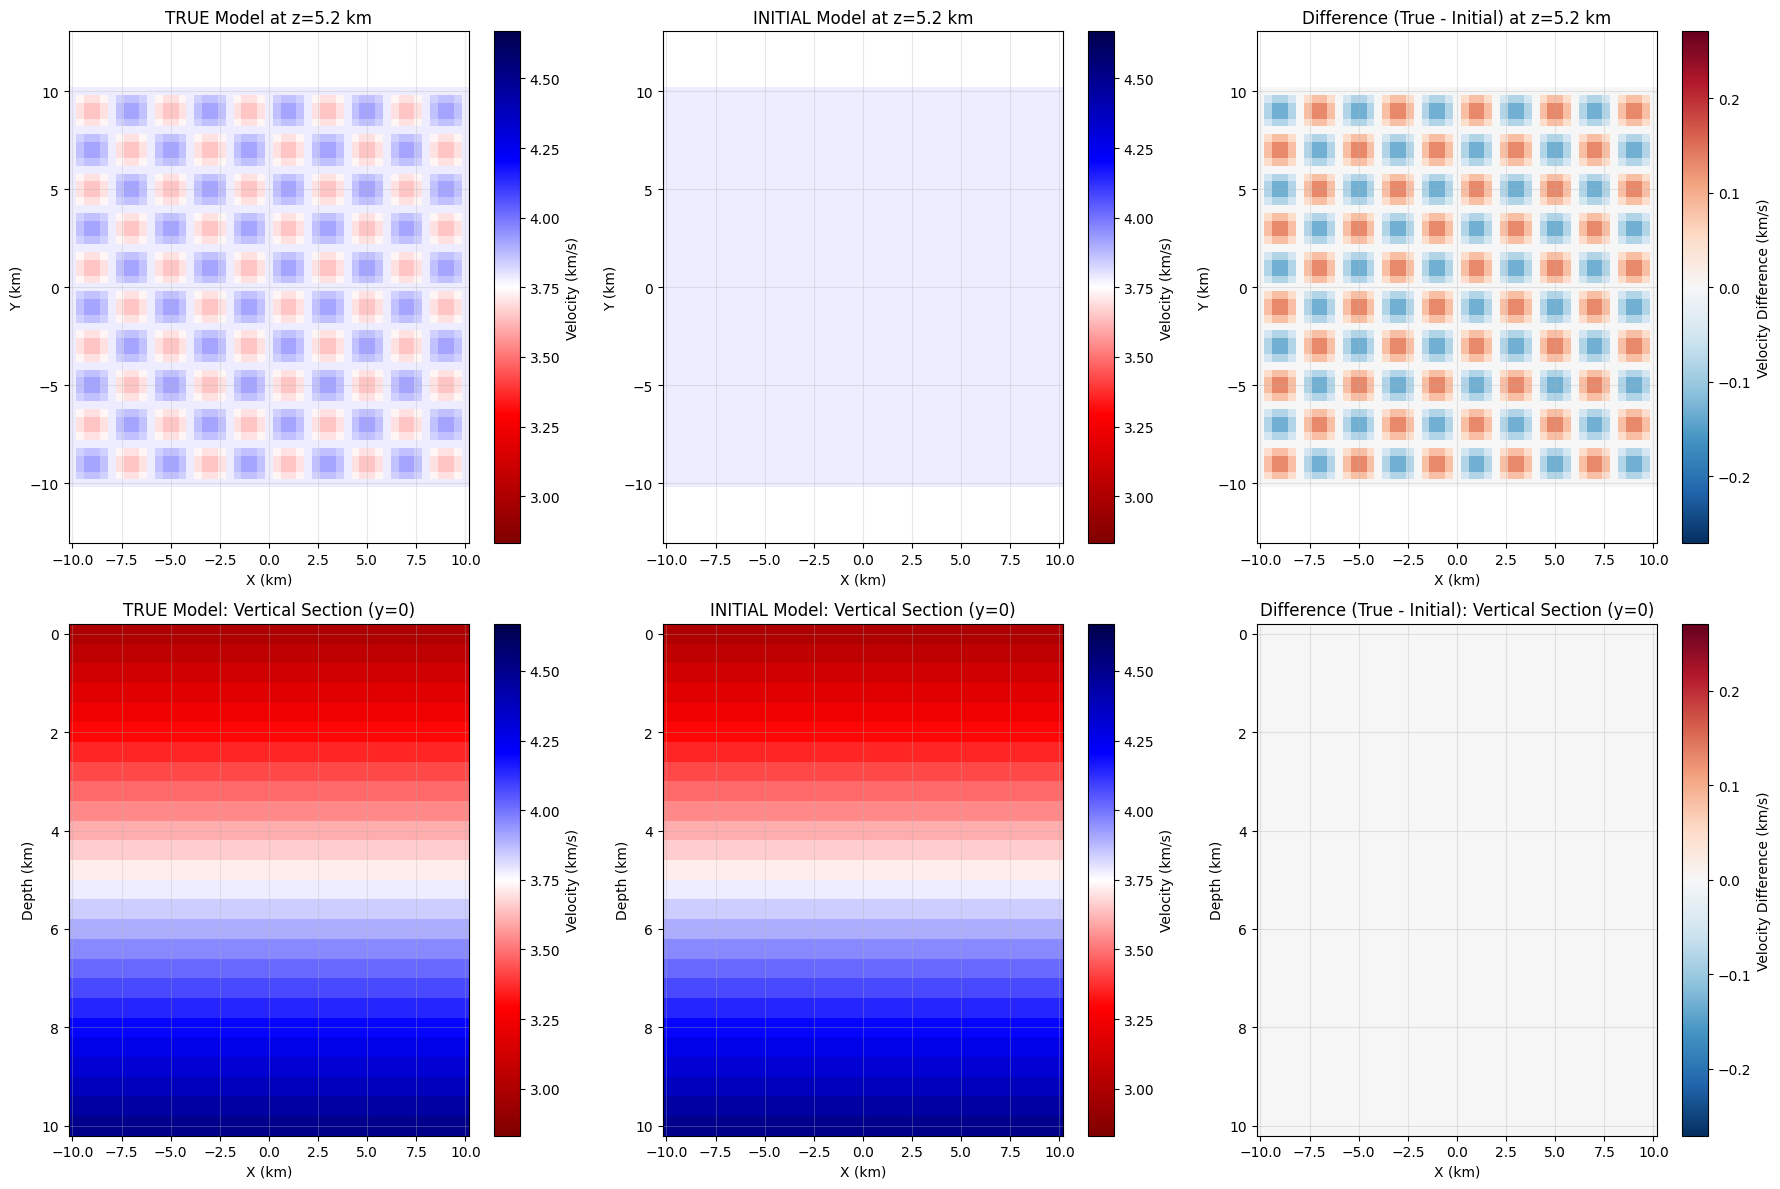

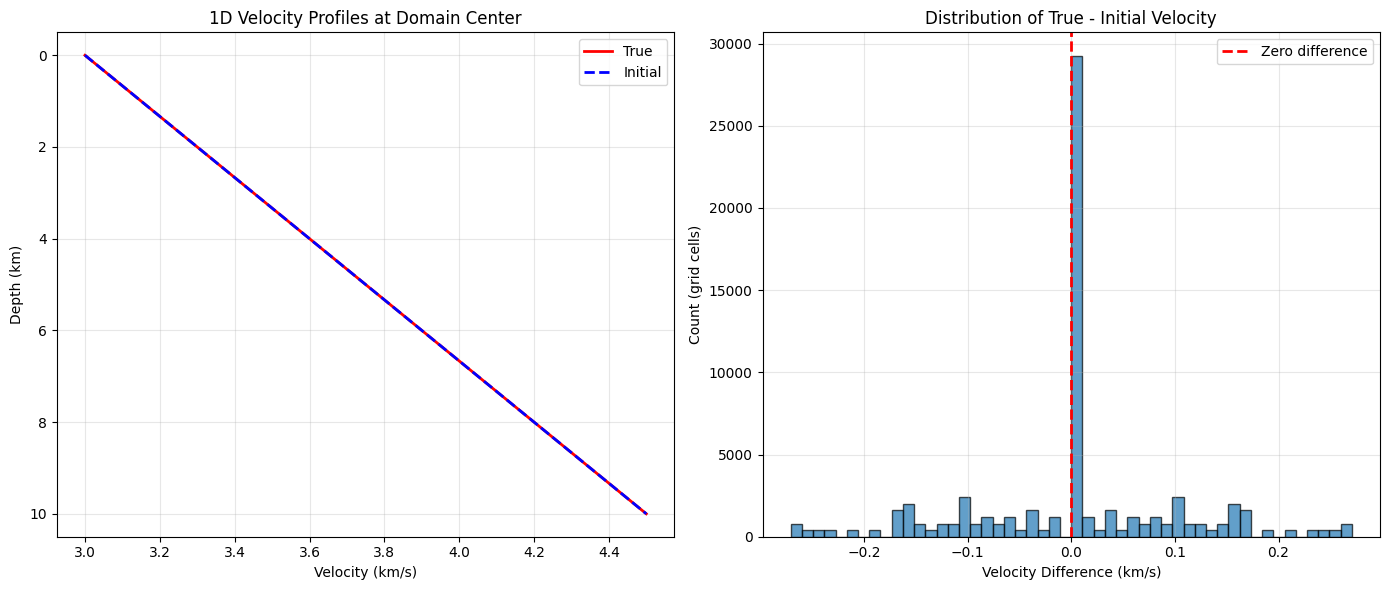


Initial model characteristics:
  Structure: Pure 1D (horizontally homogeneous)
  Missing features: All checkerboard anomalies
  Goal: Inversion should recover the 3D heterogeneity
  Challenge: Starting model has NO lateral variations!


In [10]:
# Compare initial model to true model
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Horizontal slices at mid-depth
mid_z_idx = nz // 2
z_plot = z[mid_z_idx]

# True model
ax = axes[0, 0]
im = ax.pcolormesh(X[:, :, mid_z_idx], Y[:, :, mid_z_idx], velocity_true[:, :, mid_z_idx], 
                   shading='auto', cmap='seismic_r', 
                   vmin=velocity_true.min(), vmax=velocity_true.max())
plt.colorbar(im, ax=ax, label='Velocity (km/s)')
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_title(f'TRUE Model at z={z_plot:.1f} km')
ax.axis('equal')
ax.grid(True, alpha=0.3)

# Initial model
ax = axes[0, 1]
im = ax.pcolormesh(X[:, :, mid_z_idx], Y[:, :, mid_z_idx], velocity_initial[:, :, mid_z_idx], 
                   shading='auto', cmap='seismic_r',
                   vmin=velocity_true.min(), vmax=velocity_true.max())
plt.colorbar(im, ax=ax, label='Velocity (km/s)')
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_title(f'INITIAL Model at z={z_plot:.1f} km')
ax.axis('equal')
ax.grid(True, alpha=0.3)

# Difference (what we need to recover)
ax = axes[0, 2]
diff_max = np.abs(velocity_difference).max()
im = ax.pcolormesh(X[:, :, mid_z_idx], Y[:, :, mid_z_idx], velocity_difference[:, :, mid_z_idx], 
                   shading='auto', cmap='RdBu_r',
                   vmin=-diff_max, vmax=diff_max)
plt.colorbar(im, ax=ax, label='Velocity Difference (km/s)')
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_title(f'Difference (True - Initial) at z={z_plot:.1f} km')
ax.axis('equal')
ax.grid(True, alpha=0.3)

# Row 2: Vertical cross-sections at y=0
y_mid_idx = ny // 2

# True model
ax = axes[1, 0]
im = ax.pcolormesh(X[:, y_mid_idx, :], Z[:, y_mid_idx, :], velocity_true[:, y_mid_idx, :], 
                   shading='auto', cmap='seismic_r',
                   vmin=velocity_true.min(), vmax=velocity_true.max())
plt.colorbar(im, ax=ax, label='Velocity (km/s)')
ax.set_xlabel('X (km)')
ax.set_ylabel('Depth (km)')
ax.set_title('TRUE Model: Vertical Section (y=0)')
ax.invert_yaxis()
ax.grid(True, alpha=0.3)

# Initial model
ax = axes[1, 1]
im = ax.pcolormesh(X[:, y_mid_idx, :], Z[:, y_mid_idx, :], velocity_initial[:, y_mid_idx, :], 
                   shading='auto', cmap='seismic_r',
                   vmin=velocity_true.min(), vmax=velocity_true.max())
plt.colorbar(im, ax=ax, label='Velocity (km/s)')
ax.set_xlabel('X (km)')
ax.set_ylabel('Depth (km)')
ax.set_title('INITIAL Model: Vertical Section (y=0)')
ax.invert_yaxis()
ax.grid(True, alpha=0.3)

# Difference
ax = axes[1, 2]
im = ax.pcolormesh(X[:, y_mid_idx, :], Z[:, y_mid_idx, :], velocity_difference[:, y_mid_idx, :], 
                   shading='auto', cmap='RdBu_r',
                   vmin=-diff_max, vmax=diff_max)
plt.colorbar(im, ax=ax, label='Velocity Difference (km/s)')
ax.set_xlabel('X (km)')
ax.set_ylabel('Depth (km)')
ax.set_title('Difference (True - Initial): Vertical Section (y=0)')
ax.invert_yaxis()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional comparison plot: 1D profiles
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Velocity profiles at center of domain
center_x_idx = nx // 2
center_y_idx = ny // 2

ax = axes[0]
ax.plot(velocity_true[center_x_idx, center_y_idx, :], z, 'r-', linewidth=2, label='True')
ax.plot(velocity_initial[center_x_idx, center_y_idx, :], z, 'b--', linewidth=2, label='Initial')
ax.set_xlabel('Velocity (km/s)')
ax.set_ylabel('Depth (km)')
ax.set_title('1D Velocity Profiles at Domain Center')
ax.invert_yaxis()
ax.grid(True, alpha=0.3)
ax.legend()

# Histogram of velocity differences
ax = axes[1]
ax.hist(velocity_difference.ravel(), bins=50, edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero difference')
ax.set_xlabel('Velocity Difference (km/s)')
ax.set_ylabel('Count (grid cells)')
ax.set_title('Distribution of True - Initial Velocity')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nInitial model characteristics:")
print(f"  Structure: Pure 1D (horizontally homogeneous)")
print(f"  Missing features: All checkerboard anomalies")
print(f"  Goal: Inversion should recover the 3D heterogeneity")
print(f"  Challenge: Starting model has NO lateral variations!")


## 7. Build the Fréchet (Design) Matrix G

**Strategy:** Use PyKonal to trace rays and compute path lengths through each grid cell.

In [ ]:
# Build the Fréchet (design) matrix G
# G[i,j] = path length of ray i through grid cell j
# This is a SPARSE matrix: most rays only pass through a small fraction of cells

print("Building Fréchet matrix G...")
print(f"Matrix dimensions: {n_data} data × {nx*ny*nz} parameters")
print(f"Total matrix elements: {n_data * nx * ny * nz:,}")
print("Using sparse matrix format to save memory...\n")

# Initialize sparse matrix (use lil_matrix for efficient construction)
n_params = nx * ny * nz
G = lil_matrix((n_data, n_params))

# We'll use the INITIAL velocity model to trace rays
# (In iterative inversion, this gets updated each iteration)
velocity_current = velocity_initial.copy()

# Helper function to compute ray path lengths through grid cells
def compute_ray_path_lengths(source_loc, receiver_loc, velocity_model):
    """
    Trace ray from source to receiver and compute path length through each cell.
    
    Strategy:
    1. Solve eikonal equation from source
    2. Use gradient descent from receiver back to source to trace ray
    3. Compute path length through each cell the ray traverses
    
    Returns:
    --------
    cell_indices : list of int
        Flat indices of cells the ray passes through
    path_lengths : list of float
        Path length (km) through each corresponding cell
    """
    
    # Setup PyKonal solver
    solver = pykonal.EikonalSolver(coord_sys="cartesian")
    solver.velocity.min_coords = x_min, y_min, z_min
    solver.velocity.node_intervals = (
        (x_max - x_min) / (nx - 1),
        (y_max - y_min) / (ny - 1),
        (z_max - z_min) / (nz - 1)
    )
    solver.velocity.npts = nx, ny, nz
    solver.velocity.values = velocity_model
    
    # Set source location
    src_x, src_y, src_z = source_loc
    src_idx = (
        int(np.clip((src_x - x_min) / (x_max - x_min) * (nx - 1), 0, nx - 1)),
        int(np.clip((src_y - y_min) / (y_max - y_min) * (ny - 1), 0, ny - 1)),
        int(np.clip((src_z - z_min) / (z_max - z_min) * (nz - 1), 0, nz - 1))
    )
    
    solver.traveltime.values[src_idx] = 0.0
    solver.unknown[src_idx] = False
    solver.trial.push(*src_idx)
    
    # Solve eikonal equation
    solver.solve()
    
    # Trace ray from receiver back to source using gradient descent
    rec_x, rec_y, rec_z = receiver_loc
    
    # Start from receiver
    ray_points = [np.array([rec_x, rec_y, rec_z])]
    current_point = np.array([rec_x, rec_y, rec_z])
    
    # Gradient descent parameters
    step_size = 0.1  # km
    max_steps = 1000
    
    # Create interpolator for travel time gradient
    from scipy.ndimage import sobel
    
    # Compute gradient of travel time field
    grad_t_x = sobel(solver.traveltime.values, axis=0) / solver.velocity.node_intervals[0]
    grad_t_y = sobel(solver.traveltime.values, axis=1) / solver.velocity.node_intervals[1]
    grad_t_z = sobel(solver.traveltime.values, axis=2) / solver.velocity.node_intervals[2]
    
    # Interpolators for gradient components
    interp_gx = RegularGridInterpolator((x, y, z), grad_t_x, bounds_error=False, fill_value=0)
    interp_gy = RegularGridInterpolator((x, y, z), grad_t_y, bounds_error=False, fill_value=0)
    interp_gz = RegularGridInterpolator((x, y, z), grad_t_z, bounds_error=False, fill_value=0)
    
    # Trace ray
    for step in range(max_steps):
        # Get gradient at current point
        grad = np.array([
            interp_gx(current_point)[0],
            interp_gy(current_point)[0],
            interp_gz(current_point)[0]
        ])
        
        # Normalize gradient
        grad_norm = np.linalg.norm(grad)
        if grad_norm < 1e-10:
            break
        
        grad = grad / grad_norm
        
        # Step in direction opposite to gradient (toward source)
        next_point = current_point - step_size * grad
        
        # Check if we've reached the source
        dist_to_source = np.linalg.norm(next_point - np.array([src_x, src_y, src_z]))
        if dist_to_source < step_size:
            ray_points.append(np.array([src_x, src_y, src_z]))
            break
        
        # Check if we're still in bounds
        if (next_point[0] < x_min or next_point[0] > x_max or
            next_point[1] < y_min or next_point[1] > y_max or
            next_point[2] < z_min or next_point[2] > z_max):
            break
        
        ray_points.append(next_point.copy())
        current_point = next_point
    
    # Now compute path lengths through each cell
    ray_points = np.array(ray_points)
    
    # Dictionary to accumulate path lengths per cell
    cell_path_lengths = {}
    
    # For each ray segment
    for i in range(len(ray_points) - 1):
        p1 = ray_points[i]
        p2 = ray_points[i + 1]
        segment_length = np.linalg.norm(p2 - p1)
        
        # Find which cell the midpoint is in
        mid_point = (p1 + p2) / 2
        
        ix = int(np.clip((mid_point[0] - x_min) / (x_max - x_min) * (nx - 1), 0, nx - 1))
        iy = int(np.clip((mid_point[1] - y_min) / (y_max - y_min) * (ny - 1), 0, ny - 1))
        iz = int(np.clip((mid_point[2] - z_min) / (z_max - z_min) * (nz - 1), 0, nz - 1))
        
        # Convert to flat index
        flat_idx = ix * ny * nz + iy * nz + iz
        
        # Accumulate path length
        if flat_idx in cell_path_lengths:
            cell_path_lengths[flat_idx] += segment_length
        else:
            cell_path_lengths[flat_idx] = segment_length
    
    # Convert to lists
    cell_indices = list(cell_path_lengths.keys())
    path_lengths = list(cell_path_lengths.values())
    
    return cell_indices, path_lengths

# Build G matrix by looping over all source-receiver pairs
print("Tracing rays and computing path lengths...")
print("This will take several minutes...\n")

for i_data in range(n_data):
    if (i_data + 1) % 250 == 0 or i_data == 0:
        print(f"  Processing ray {i_data + 1}/{n_data} ({100*(i_data+1)/n_data:.1f}%)...")
    
    # Get source and receiver for this data point
    i_src = source_indices[i_data]
    i_rec = receiver_indices[i_data]
    
    src_loc = source_coords[i_src]
    rec_loc = receiver_coords[i_rec]
    
    # Compute ray path lengths
    cell_idx, path_len = compute_ray_path_lengths(src_loc, rec_loc, velocity_current)
    
    # Fill G matrix
    for idx, length in zip(cell_idx, path_len):
        G[i_data, idx] = length

# Convert to CSR format for efficient operations
G = G.tocsr()

print(f"\nFréchet matrix G constructed!")
print(f"  Matrix shape: {G.shape}")
print(f"  Number of non-zero elements: {G.nnz:,}")
print(f"  Sparsity: {100 * (1 - G.nnz / (n_data * n_params)):.2f}% zeros")
print(f"  Average non-zeros per row (ray): {G.nnz / n_data:.1f} cells")
print(f"  Memory saved by sparse format: {100 * (1 - G.nnz / (n_data * n_params)):.1f}%")

Building Fréchet matrix G...
Matrix dimensions: 2025 data × 67626 parameters
Total matrix elements: 136,942,650
Using sparse matrix format to save memory...

Tracing rays and computing path lengths...
This will take several minutes...

  Processing ray 1/2025 (0.0%)...
  Processing ray 250/2025 (12.3%)...
  Processing ray 250/2025 (12.3%)...
  Processing ray 500/2025 (24.7%)...
  Processing ray 500/2025 (24.7%)...
  Processing ray 750/2025 (37.0%)...
  Processing ray 750/2025 (37.0%)...


### Visualize G Matrix Sparsity Pattern

In [ ]:
# Visualize the sparsity pattern of G matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Sparsity pattern (subsampled for visualization)
ax = axes[0]
# Subsample for visualization
subsample_data = max(1, n_data // 500)
subsample_param = max(1, n_params // 500)

G_sub = G[::subsample_data, ::subsample_param]
ax.spy(G_sub, markersize=0.5, aspect='auto')
ax.set_xlabel(f'Parameter Index (subsampled by {subsample_param})')
ax.set_ylabel(f'Data Index (subsampled by {subsample_data})')
ax.set_title(f'G Matrix Sparsity Pattern\n({G.nnz:,} non-zeros, {100*(1-G.nnz/(n_data*n_params)):.1f}% sparse)')

# Plot 2: Histogram of non-zero values
ax = axes[1]
nonzero_vals = G.data
ax.hist(nonzero_vals, bins=50, edgecolor='black', alpha=0.7)
ax.set_xlabel('Path Length (km)')
ax.set_ylabel('Count')
ax.set_title(f'Distribution of Ray Path Lengths\n(mean: {nonzero_vals.mean():.3f} km)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nG matrix statistics:")
print(f"  Non-zero path lengths:")
print(f"    Min: {nonzero_vals.min():.4f} km")
print(f"    Max: {nonzero_vals.max():.4f} km")
print(f"    Mean: {nonzero_vals.mean():.4f} km")
print(f"    Median: {np.median(nonzero_vals):.4f} km")

### Analyze Design Matrix Properties

## 8. Solve the Inverse Problem (Damped Least Squares)

Solve for slowness perturbations using regularized inversion.

In [ ]:
# TODO: Compute travel-time residuals (d_obs - d_pred)
# TODO: Set damping parameter epsilon
# TODO: Solve: m = (G^T G + eps^2 I)^{-1} G^T d  [or use lsqr]
# TODO: Convert slowness perturbation back to velocity perturbation
# TODO: Update velocity model

### Visualize Inverted Model (Single Iteration)

In [ ]:
# TODO: Plot recovered velocity model
# TODO: Compare to true model (residual/difference)
# TODO: Compute misfit reduction

## 9. Iterative Inversion

Repeat the inversion with updated model until convergence.

In [ ]:
# TODO: Implement iteration loop
# TODO: For each iteration:
#       - Compute predicted data using current model
#       - Build new G matrix (rays change as model updates)
#       - Solve for velocity update
#       - Apply update with step length control
#       - Track misfit vs. iteration
# TODO: Plot convergence curve

### Compare Final Model to True Model

In [ ]:
# TODO: Side-by-side plots: true vs. recovered velocity
# TODO: Compute correlation, RMS error
# TODO: Identify well-recovered vs. poorly-recovered regions

## 10. Resolution Analysis: Checkerboard Test

**Purpose:** Assess which parts of the model are well-resolved by the data.

**Method:**
1. Create synthetic checkerboard velocity model
2. Generate synthetic data using same source-receiver geometry
3. Invert data starting from smooth background
4. Examine recovery of checkerboard pattern

In [ ]:
# TODO: Create checkerboard velocity anomalies
# TODO: Compute synthetic travel times through checkerboard
# TODO: Invert using same workflow as above
# TODO: Visualize input vs. recovered checkerboard

### Interpret Checkerboard Results

In [ ]:
# TODO: Identify regions with good recovery (sharp checkerboard pattern)
# TODO: Identify smeared/damped regions (poor resolution)
# TODO: Relate poor resolution to lack of crossing ray paths

## 11. Explore Effect of Ray Path Coverage

**Experiment:** Start with few earthquakes, progressively add more, and observe resolution improvement.

In [ ]:
# TODO: Define scenarios with increasing number of earthquakes
#       - Scenario 1: 5 earthquakes
#       - Scenario 2: 15 earthquakes
#       - Scenario 3: 50 earthquakes
# TODO: For each scenario, invert data and compare recovery quality
# TODO: Plot model quality vs. number of sources

### Visualize Ray Coverage Evolution

In [ ]:
# TODO: Plot ray hit count maps for each scenario
# TODO: Show how adding sources fills in coverage gaps
# TODO: Relate coverage to model uncertainty

## 12. Data Covariance, Rank, and Redundancy

**Concepts:**
- **Parallel rays:** Provide redundant information (high correlation in data covariance)
- **Crossing rays:** Provide independent constraints (low correlation)
- **Rank deficiency:** Occurs when data contain less independent information than assumed

**Analysis:**
- Compute data covariance $C_d$ from residuals across multiple realizations
- Perform eigenvalue decomposition to assess effective rank
- Identify redundant vs. informative data components

In [ ]:
# TODO: Compute G^T G and analyze eigenvalues
# TODO: Plot eigenvalue spectrum (shows information content)
# TODO: Identify null space and poorly constrained modes
# TODO: Simulate data covariance for parallel vs. crossing ray scenarios

## 13. Model Uncertainty Quantification

**Approaches:**
- **Diagonal of model covariance:** $\text{diag}(C_m) = \text{diag}((G^T G + \epsilon^2 I)^{-1})$
- **Bootstrap:** Resample data and re-invert many times
- **Resolution matrix:** Examine diagonal and off-diagonal elements
- **Checkerboard amplitude recovery:** Ratio of recovered to input amplitude

In [ ]:
# TODO: Compute model covariance (or approximate diagonal)
# TODO: Plot uncertainty maps (standard deviation per cell)
# TODO: Overlay with ray hit count
# TODO: Confirm that uncertainty is high where coverage is low

## 14. Damping and Smoothing Trade-offs

**L-curve analysis:** Plot model norm vs. data misfit for various damping parameters to find optimal regularization.

In [ ]:
# TODO: Solve inversion for range of damping parameters
# TODO: Compute ||Gm - d||^2 (data misfit) and ||m||^2 (model norm)
# TODO: Plot L-curve
# TODO: Identify corner (optimal damping)

## 15. Summary and Discussion

### Key Results:

1. **Forward Problem:** Generated synthetic travel-time data from known velocity model
2. **Inverse Problem:** Iteratively recovered 3D velocity structure from travel times
3. **Resolution:** Used checkerboard tests to assess spatial resolution
4. **Coverage:** Demonstrated importance of crossing ray paths for good resolution
5. **Uncertainty:** Quantified model uncertainty and linked it to ray coverage

### Important Observations:

- **Resolution vs. Coverage:** Well-sampled regions (crossing rays) show better recovery
- **Iteration:** Nonlinear problem requires multiple iterations; rays change as model updates
- **Regularization:** Damping/smoothing essential to stabilize ill-posed problem
- **Checkerboard:** Direct visualization of what features can/cannot be resolved
- **Redundancy:** Parallel rays add little new information; crossing rays critical

### Extensions to Try:

1. **Realistic geology:** Replace checkerboard with subduction zone, sedimentary basin, etc.
2. **Joint inversion:** Simultaneously solve for velocity structure and earthquake locations
3. **Adaptive parameterization:** Use finer grid where resolution is good, coarser where poor
4. **Anisotropy:** Extend to azimuthally anisotropic velocity
5. **Attenuation tomography:** Invert amplitude data for Q structure
6. **Surface waves:** Add dispersion measurements for shallow structure

### Real-World Applications:

- **Regional tomography:** Crustal and upper mantle structure
- **Local tomography:** Volcano imaging, fault zone structure
- **Global tomography:** Whole-mantle heterogeneity, subducted slabs
- **Exploration geophysics:** Oil/gas reservoirs, mineral deposits
- **Engineering:** Site characterization, landslide imaging

## 16. Exercise Questions

1. **How does damping affect model recovery?**
   - Run inversions with very small and very large damping
   - Which produces better data fit? Which produces more realistic models?

2. **What is the minimum ray coverage needed?**
   - Remove sources progressively and observe when recovery fails
   - Is there a threshold number of crossing rays per cell?

3. **How do you choose checkerboard size?**
   - Try different checkerboard wavelengths (coarse vs. fine)
   - What happens when checkerboard is finer than resolvable scale?

4. **Does iteration converge?**
   - Plot misfit reduction vs. iteration number
   - When should you stop iterating?

5. **What about noise?**
   - Increase data noise level and observe effect on recovered model
   - Does regularization help mitigate noise?

6. **Can you detect the null space?**
   - Identify velocity perturbations that produce zero travel-time change
   - Relate to ray geometry (e.g., anomalies between ray paths)

7. **Sparse vs. dense networks:**
   - Compare recovery using a sparse receiver array vs. dense array
   - How does receiver spacing affect horizontal resolution?